In [1]:
!pip install torch torchaudio numpy pandas scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
import zipfile
import requests
import shutil
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset URL and extraction path
DATASET_URL = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
DATASET_PATH = "ravdess_audio.zip"
EXTRACT_PATH = "ravdess_data"

# Download the dataset
def download_and_extract():
    if not os.path.exists(EXTRACT_PATH):
        print("Downloading dataset...")
        response = requests.get(DATASET_URL, stream=True)
        with open(DATASET_PATH, "wb") as file:
            shutil.copyfileobj(response.raw, file)

        print("Extracting dataset...")
        with zipfile.ZipFile(DATASET_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Dataset downloaded and extracted.")
    else:
        print("Dataset already exists. Skipping download.")

download_and_extract()

# Function to get file paths and labels
def get_file_paths_and_labels():
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    file_paths = []
    labels = []

    for root, _, files in os.walk(EXTRACT_PATH):
        for file in files:
            if file.endswith(".wav"):
                file_paths.append(os.path.join(root, file))
                emotion_code = file.split("-")[2]  # Extract emotion label
                labels.append(emotion_map[emotion_code])

    return file_paths, labels

file_paths, labels = get_file_paths_and_labels()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Split dataset
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, encoded_labels, test_size=0.2, random_state=42)

# Load Wav2Vec 2.0 processor
# processor = Wav2Vec2Processor.from_pretrained("superb/wav2vec2-base-superb-er")
processor = Wav2Vec2Processor.from_pretrained("audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim")

# Define custom dataset
class EmotionDataset(Dataset):
    def __init__(self, file_paths, labels, processor, target_sample_rate=16000, max_length=16000*3):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor
        self.target_sample_rate = target_sample_rate
        self.max_length = max_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.file_paths[idx])

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)

        num_samples = waveform.shape[1]
        if num_samples > self.max_length:
            waveform = waveform[:, :self.max_length]
        else:
            pad_amount = self.max_length - num_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))

        waveform = waveform.squeeze(0)

        inputs = self.processor(
            waveform.numpy(),
            sampling_rate=self.target_sample_rate,
            return_tensors="pt",
            padding=True
        )
        return inputs.input_values.squeeze(0), torch.tensor(self.labels[idx])

# Create data loaders
train_dataset = EmotionDataset(train_files, train_labels, processor)
test_dataset = EmotionDataset(test_files, test_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load pre-trained Wav2Vec 2.0 model
model = Wav2Vec2ForSequenceClassification.from_pretrained("audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim", num_labels=len(label_encoder.classes_))

# Define optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Training loop
def train_model(model, train_loader, optimizer, criterion, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

train_model(model, train_loader, optimizer, criterion)

# Save model
torch.save(model.state_dict(), "emotion_recognition_model.pth")
print("Model training complete and saved.")

Extracting dataset...
Dataset downloaded and extracted.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30, Loss: 2.0761
Epoch 2/30, Loss: 2.0621
Epoch 3/30, Loss: 2.0408
Epoch 4/30, Loss: 1.9989
Epoch 5/30, Loss: 1.9116
Epoch 6/30, Loss: 1.8082
Epoch 7/30, Loss: 1.7221
Epoch 8/30, Loss: 1.6643
Epoch 9/30, Loss: 1.6081
Epoch 10/30, Loss: 1.5666
Epoch 11/30, Loss: 1.5015
Epoch 12/30, Loss: 1.4410
Epoch 13/30, Loss: 1.4150
Epoch 14/30, Loss: 1.3235
Epoch 15/30, Loss: 1.2711
Epoch 16/30, Loss: 1.2475
Epoch 17/30, Loss: 1.1554
Epoch 18/30, Loss: 1.1366
Epoch 19/30, Loss: 1.0938
Epoch 20/30, Loss: 1.0374
Epoch 21/30, Loss: 0.9561
Epoch 22/30, Loss: 0.9368
Epoch 23/30, Loss: 0.8904
Epoch 24/30, Loss: 0.8094
Epoch 25/30, Loss: 0.7705
Epoch 26/30, Loss: 0.7622
Epoch 27/30, Loss: 0.8168
Epoch 28/30, Loss: 0.8060
Epoch 29/30, Loss: 0.7228
Epoch 30/30, Loss: 0.6739
Model training complete and saved.


Accuracy: 0.7673611111111112
Classification Report:
              precision    recall  f1-score   support

       angry       0.85      0.85      0.85        41
        calm       0.92      0.77      0.84        43
     disgust       0.87      0.77      0.82        35
     fearful       0.74      0.82      0.78        38
       happy       0.85      0.50      0.63        44
     neutral       0.48      1.00      0.65        15
         sad       0.69      0.63      0.66        35
   surprised       0.73      0.97      0.84        37

    accuracy                           0.77       288
   macro avg       0.77      0.79      0.76       288
weighted avg       0.79      0.77      0.77       288



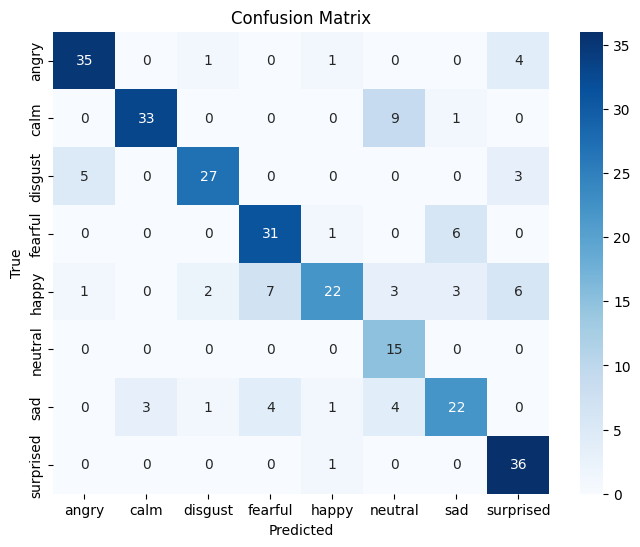

In [3]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)

In [1]:
import torchaudio.transforms as T
import torch.optim as optim

# Define data augmentation functions
def augment_audio(waveform, sample_rate=16000):
    pitch_shift = T.PitchShift(sample_rate=sample_rate, n_steps=2)
    add_noise = lambda x: x + 0.005 * torch.randn_like(x)

    if torch.rand(1) < 0.3:
        waveform = pitch_shift(waveform)  # No need to detach
    if torch.rand(1) < 0.3:
        waveform = add_noise(waveform)  # No need to detach

    return waveform

# Modify dataset to apply augmentation
class AugmentedEmotionDataset(EmotionDataset):
    def __getitem__(self, idx):
        waveform, label = super().__getitem__(idx)

        # Ensure waveform is detached and cloned before augmentation
        waveform = waveform.clone().detach()

        if torch.rand(1) < 0.5:  # 50% chance to apply augmentation
            waveform = augment_audio(waveform)

        return waveform, label

# Fine-tune with reduced learning rate and more epochs
new_train_dataset = AugmentedEmotionDataset(train_files, train_labels, processor)
new_train_loader = DataLoader(new_train_dataset, batch_size=8, shuffle=True)

# Use a lower learning rate for fine-tuning
fine_tune_optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

# Fine-tune for 20 more epochs
def fine_tune_model(model, train_loader, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs are properly detached and are leaf tensors
            inputs = inputs.clone().detach()  # Removes the computation graph

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Fine-Tuning Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Call fine-tune function
fine_tune_model(model, new_train_loader, fine_tune_optimizer, criterion, epochs=20)

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_emotion_recognition_model.pth")
print("Fine-tuning complete and model saved.")

NameError: name 'EmotionDataset' is not defined